In [1]:
LOAD_FROM_CACHE = False

In [2]:
from pytorch_transformers import GPT2Tokenizer
from experiment import Intervention, Model
from attention_utils import perform_interventions, report_intervention, report_interventions_summary_by_head, report_interventions_summary_by_layer
import pandas as pd
import json
import os

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = Model(output_attentions=True)

In [4]:
# Test experiment
interventions = [
	Intervention(
        tokenizer,
        "The doctor asked the nurse a question. {}",
        ["He", "She"],
        ["asked", "answered"]),
	Intervention(
        tokenizer,
        "The doctor asked the nurse a question. {}",
        ["He", "She"],
        ["requested", "responded"]),
	Intervention(
        tokenizer,
        "The man felt sorry about what he said to the woman. {}",
        ["He", "She"],
        ["apologized", "forgave"]),
	Intervention(
        tokenizer,
        "The nurse notified the patient that {}",
        ["her", "his"],
        ["shift", "blood"])
]

# dirname = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname(__file__)))
path = 'test_attn_int.json'
if not LOAD_FROM_CACHE:
	results = perform_interventions(interventions, model)
	with open(path, 'w') as f:
		json.dump(results, f)
with open(path) as f:
	results = json.load(f)


100%|██████████| 4/4 [01:18<00:00, 19.59s/it]


x : The doctor asked the nurse a question. He
x': The doctor asked the nurse a question. She
c1: asked
c2: answered

p(c2|x) / p(c1|x) = 0.06125
p(c2|x') / p(c1|x') = 0.37261

TOTAL Effect: (p(c2|x') / p(c1|x')) / (p(c2|x) / p(c1|x)) - 1 = 5.084


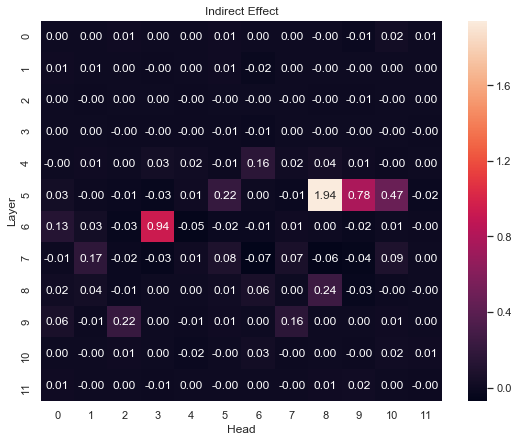

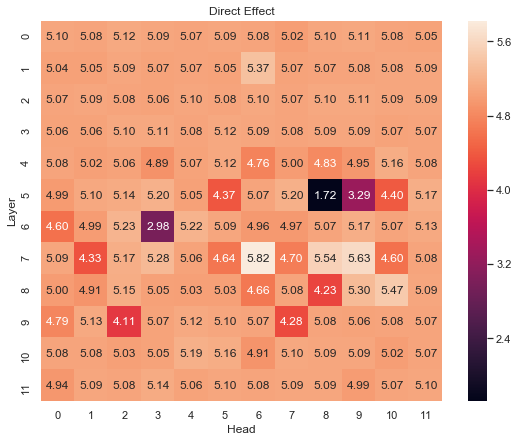

In [5]:
report_intervention(results[0])

x : The doctor asked the nurse a question. He
x': The doctor asked the nurse a question. She
c1: requested
c2: responded

p(c2|x) / p(c1|x) = 5.60562
p(c2|x') / p(c1|x') = 48.40155

TOTAL Effect: (p(c2|x') / p(c1|x')) / (p(c2|x) / p(c1|x)) - 1 = 7.634


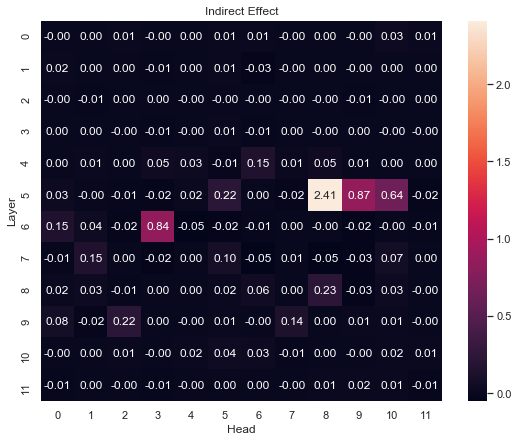

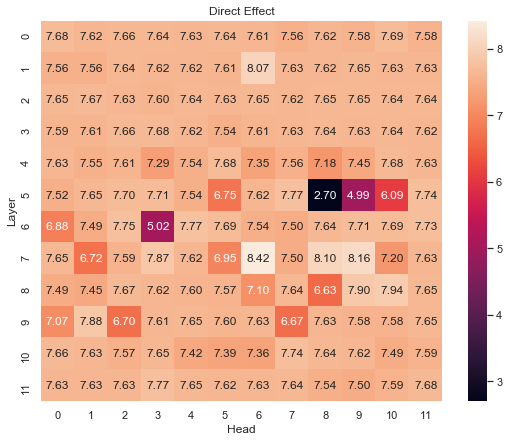

In [6]:
report_intervention(results[1])

x : The man felt sorry about what he said to the woman. He
x': The man felt sorry about what he said to the woman. She
c1: apologized
c2: forg ave

p(c2|x) / p(c1|x) = 1.22404
p(c2|x') / p(c1|x') = 3.17622

TOTAL Effect: (p(c2|x') / p(c1|x')) / (p(c2|x) / p(c1|x)) - 1 = 1.595


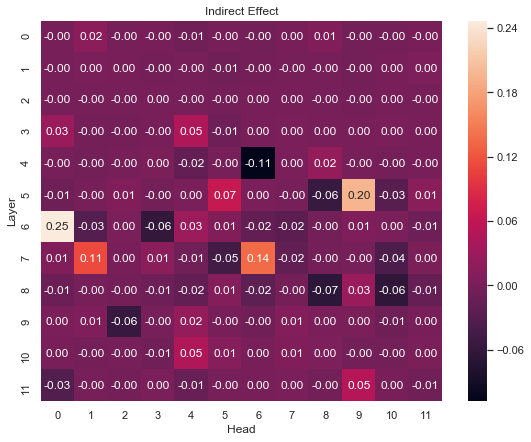

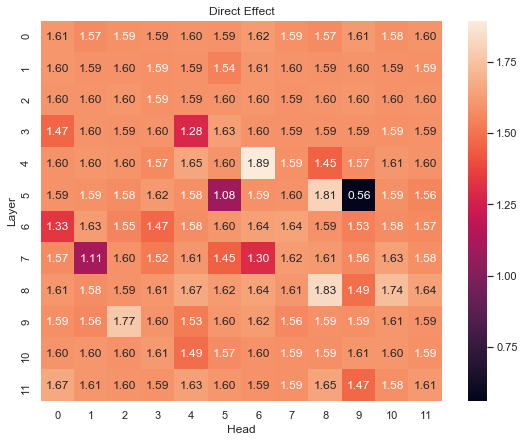

In [7]:
report_intervention(results[2])

x : The nurse notified the patient that her
x': The nurse notified the patient that his
c1: shift
c2: blood

p(c2|x) / p(c1|x) = 41.54527
p(c2|x') / p(c1|x') = 102.70793

TOTAL Effect: (p(c2|x') / p(c1|x')) / (p(c2|x) / p(c1|x)) - 1 = 1.472


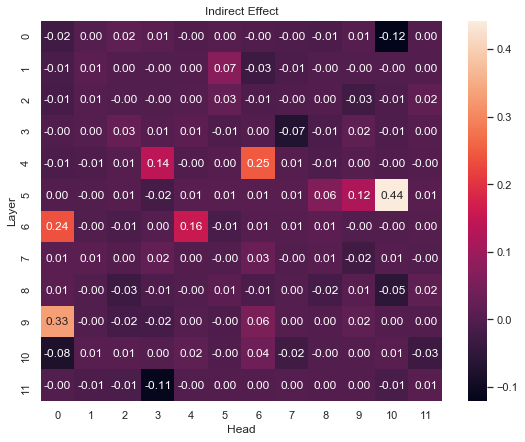

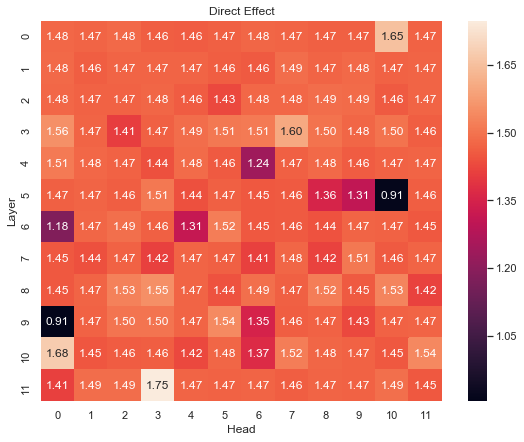

In [8]:
report_intervention(results[3])

*** SUMMARY BY HEAD ***
Num interventions: 4
Mean total effect: 3.95

INDIRECT Effect (mean = 0.024245090179350528)
Top 10 heads:
   5 8: 1.0898158559575677 (p=0.0000)
   5 9: 0.4910916704684496 (p=0.0000)
   6 3: 0.43202707660384476 (p=0.0000)
   5 10: 0.38360574981197715 (p=0.0000)
   6 0: 0.1915331855416298 (p=0.0169)
   5 5: 0.1275142647791654 (p=0.0950)
   9 0: 0.1198737882077694 (p=0.1126)
   7 1: 0.11238250508904457 (p=0.1314)
   4 6: 0.11199403554201126 (p=0.1329)
   8 8: 0.0975129040889442 (p=0.1765)

DIRECT Effect (mean = 3.8832098005546465)
Top 10 heads:
   5 8: 1.8957476019859314 (p=0.0602)
   5 9: 2.5370954275131226 (p=0.1466)
   6 3: 2.735094368457794 (p=0.1848)
   5 10: 3.2487245053052902 (p=0.3102)
   7 1: 3.4001869559288025 (p=0.3531)
   5 5: 3.4183375239372253 (p=0.3584)
   9 7: 3.492840975522995 (p=0.3803)
   6 0: 3.4994650185108185 (p=0.3823)
   9 2: 3.5203405916690826 (p=0.3885)
   8 8: 3.5515149235725403 (p=0.3978)


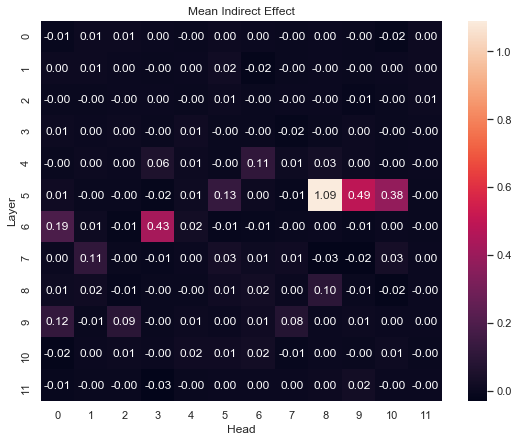

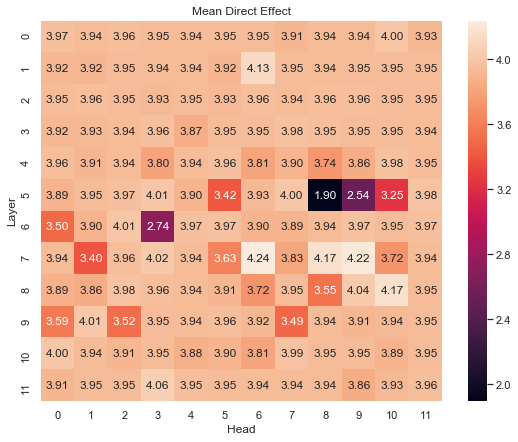

In [9]:
report_interventions_summary_by_head(results)

*** SUMMARY BY LAYER ***
Num interventions: 4
Mean total effect: 3.95


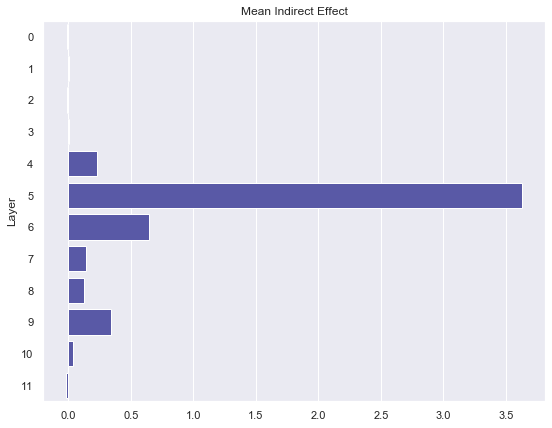

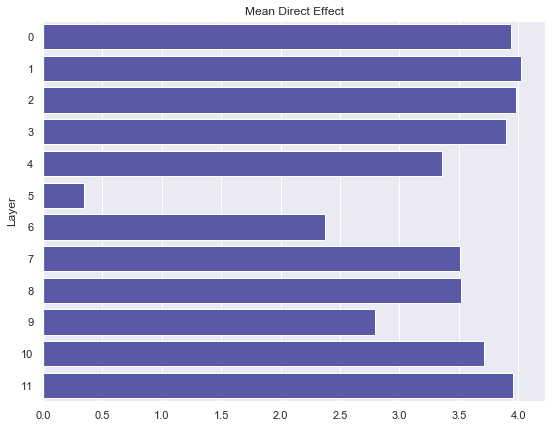

In [10]:
report_interventions_summary_by_layer(results)